In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img,plot_model
from keras.layers import Layer
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D , BatchNormalization,  Activation

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
train_dir = '../input/facial-expression-dataset/train/train/'
test_dir = '../input/facial-expression-dataset/test/test/'

In [5]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [6]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_dir)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,../input/facial-expression-dataset/train/train...,angry
1,../input/facial-expression-dataset/train/train...,angry
2,../input/facial-expression-dataset/train/train...,sad
3,../input/facial-expression-dataset/train/train...,happy
4,../input/facial-expression-dataset/train/train...,sad


In [7]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(test_dir)
test.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,../input/facial-expression-dataset/test/test/s...,surprise
1,../input/facial-expression-dataset/test/test/s...,surprise
2,../input/facial-expression-dataset/test/test/s...,surprise
3,../input/facial-expression-dataset/test/test/s...,surprise
4,../input/facial-expression-dataset/test/test/s...,surprise


In [8]:
print(f"length of dataframe: {train.shape[0]}; columns in dataframe {train.shape[1]}")
print("------")
print("List of columns")
[print(x) for x in train.columns]
print("------")
train.info()

length of dataframe: 28709; columns in dataframe 2
------
List of columns
image
label
------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   28709 non-null  object
 1   label   28709 non-null  object
dtypes: object(2)
memory usage: 448.7+ KB


In [9]:
print(f"length of dataframe: {test.shape[0]}; columns in dataframe {test.shape[1]}")
print("------")
print("List of columns")
[print(x) for x in test.columns]
print("------")
test.info()

length of dataframe: 7178; columns in dataframe 2
------
List of columns
image
label
------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7178 entries, 0 to 7177
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   7178 non-null   object
 1   label   7178 non-null   object
dtypes: object(2)
memory usage: 112.3+ KB


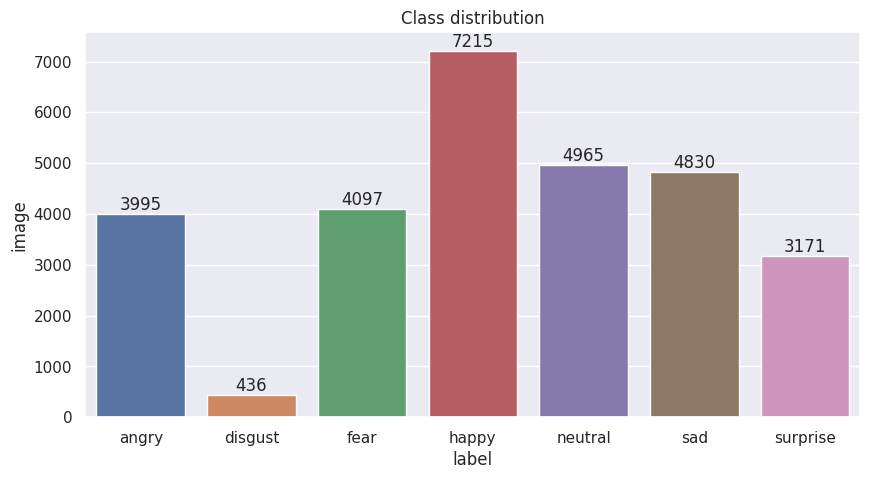

In [10]:
train_plot = train.groupby('label').count().reset_index()

ax = sns.set_theme(rc={'figure.figsize':(10,5)})
ax = sns.barplot(train_plot, x="label", y="image")
plt.title('Class distribution')
ax.bar_label(ax.containers[0])
plt.show()

In [11]:
train= train[train.label !='disgust']

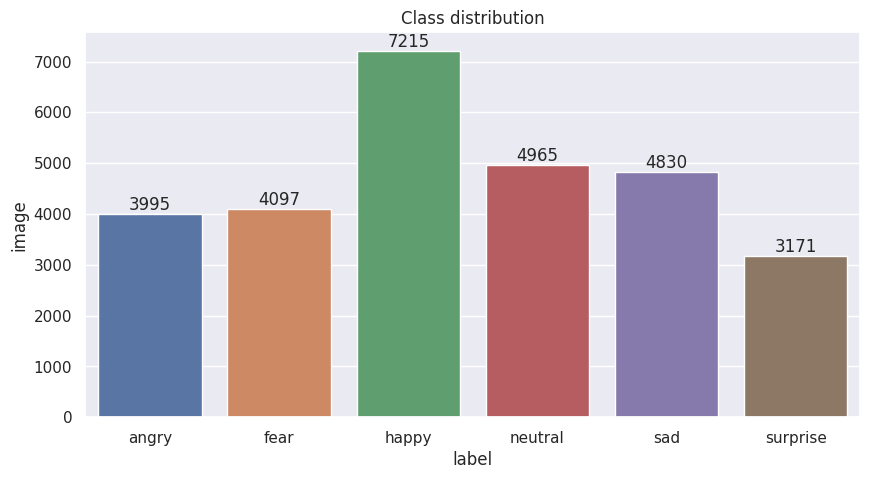

In [12]:
train_plot = train.groupby('label').count().reset_index()

ax = sns.set_theme(rc={'figure.figsize':(10,5)})
ax = sns.barplot(train_plot, x="label", y="image")
plt.title('Class distribution')
ax.bar_label(ax.containers[0])
plt.show()

In [13]:
# #Applying undersampling
# def undersampling(microCount, k=3171):
#   if len(microCount) < k:
#     return microCount
#   return microCount.sample(k)

In [14]:
# train = train.groupby('label').apply(undersampling).reset_index(drop=True)
# train ['label'].value_counts()

In [15]:
# train_plot = train.groupby('label').count().reset_index()

# ax = sns.set_theme(rc={'figure.figsize':(10,5)})
# ax = sns.barplot(train_plot, x="label", y="image")
# plt.title('Class distribution')
# ax.bar_label(ax.containers[0])
# plt.show()

In [16]:
# from keras.preprocessing.image import ImageDataGenerator

# train = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

In [17]:
test= test[test.label !='disgust']

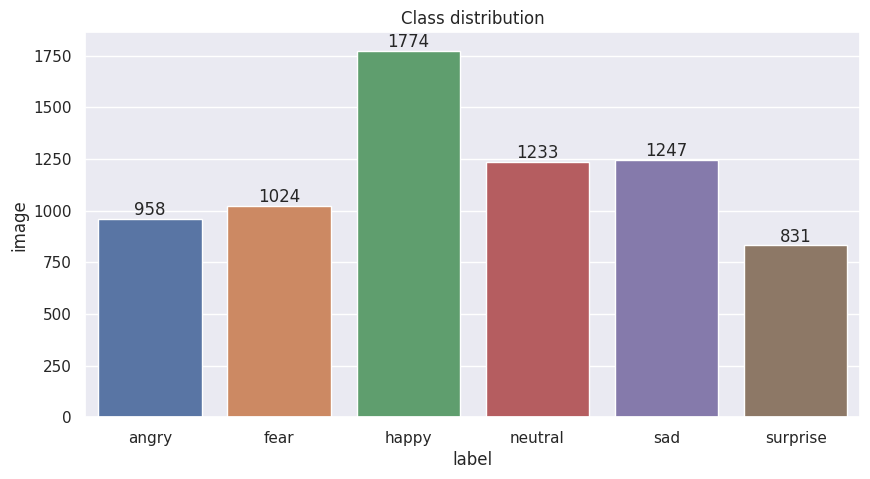

In [18]:
test_plot = test.groupby('label').count().reset_index()

ax = sns.set_theme(rc={'figure.figsize':(10,5)})
ax = sns.barplot(test_plot, x="label", y="image")
plt.title('Class distribution')
ax.bar_label(ax.containers[0])
plt.show()

In [19]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [20]:
train_features = extract_features(train['image'])

  0%|          | 0/28273 [00:00<?, ?it/s]

In [21]:
test_features = extract_features(test['image'])


  0%|          | 0/7067 [00:00<?, ?it/s]

In [22]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [23]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [24]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [25]:
#initialize parameters
width, height = (48, 48)
output_class = 7
# num_features = 64
# num_epochs = 100
# batch_size = 256

In [26]:
num_classes=7
from keras.layers import Layer
import torch.nn as nn

class Softmax(Layer):

    def __init__(self, num_classes):
        super(Softmax, self).__init__()
        self.num_classes = num_classes

    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                                 shape=(input_shape[-1], self.num_classes),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='b',
                                 shape=(self.num_classes,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W) + self.b
        return tf.nn.softmax(logits)

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(Softmax, self).get_config()
        config['num_classes'] = self.num_classes
        return config

In [27]:
# epochs = 100
# batch_size=256
# steps_per_epoch = x_train.shape[0]// batch_size

In [28]:
# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#   0.001,
#   decay_steps=steps_per_epoch * 10,
#   decay_rate=1,
#   staircase=False)

In [29]:
# step = np.linspace(0,10000)
# lr = lr_schedule(step)
# plt.figure(figsize = (8,6))
# plt.plot(step/steps_per_epoch, lr)
# plt.ylim([0,max(plt.ylim())])
# plt.xlabel('Epoch')
# _ = plt.ylabel('Learning Rate')

In [30]:
from tensorflow import keras

In [31]:
# model = Sequential()

# # convolutional layers

# #model 1

# model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(width, height, 1)))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.4))

# #model 2

# model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.4))

# # #model 3

# # model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
# # model.add(MaxPooling2D(pool_size=(2,2)))
# # model.add(Dropout(0.4))

# # #model 4

# # model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
# # model.add(MaxPooling2D(pool_size=(2,2)))
# # model.add(Dropout(0.4))

# #flatten

# model.add(Flatten())

# # fully connected layers

# # #dense 1

# # model.add(Dense(512, activation='relu'))
# # model.add(Dropout(0.4))

# #dense 2

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.3))

# # output layer
# model.add(Dense(7, activation='relu'))
# model.add(Softmax())
# #model.add(Dense(output_class, activation='softmax'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [32]:
# model = Sequential()

# #module 1
# model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last'))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))
# model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Dropout(0.4))
# #module 2
# model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))
# model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu' ,padding='same'))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# #module 3
# model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))
# model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Dropout(0.4))
# #flatten
# model.add(Flatten())

# #dense 1
# model.add(Dense(2*2*2*num_features))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.4))
# #dense 2
# model.add(Dense(2*2*num_features))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.4))
# #dense 3
# model.add(Dense(2*num_features))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
# #output layer
# model.add(Dense(7))
# model.add(Softmax(num_classes = 7))

# model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),metrics=['accuracy'])

In [33]:
from tensorflow.keras import regularizers

In [34]:
model = Sequential()

# convolutional layers

#model 1
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(width, height, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

#model 2
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

#model 3
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

#model 4
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

#flatten
model.add(Flatten())
# fully connected layers

#dense 1
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

#dense 2
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(7))
model.add(Softmax(num_classes = 7))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [35]:
#     model = Sequential()

#     model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(width, height, 1),activation='relu',padding='same',kernel_initializer='he_normal',name='conv2d_1' ))
#     model.add(BatchNormalization(name='batchnorm_1'))
    
#     model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal',name='conv2d_2' ))
#     model.add(BatchNormalization(name='batchnorm_2'))
#     model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
#     model.add(Dropout(0.4, name='dropout_1'))

#     model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same',kernel_initializer='he_normal', name='conv2d_3' ))
#     model.add(BatchNormalization(name='batchnorm_3'))
    
#     model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal', name='conv2d_4'))
#     model.add(BatchNormalization(name='batchnorm_4'))
#     model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
#     model.add(Dropout(0.4, name='dropout_2'))

#     model.add( Conv2D(filters=256,kernel_size=(3,3), activation='relu',padding='same', kernel_initializer='he_normal', name='conv2d_5' ))
#     model.add(BatchNormalization(name='batchnorm_5'))
    
#     model.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal',name='conv2d_6'))
#     model.add(BatchNormalization(name='batchnorm_6'))
#     model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
#     model.add(Dropout(0.4, name='dropout_3'))

#     model.add(Flatten(name='flatten'))
        
#     model.add(Dense(128,activation='relu', kernel_initializer='he_normal',name='dense_1' ))
#     model.add(BatchNormalization(name='batchnorm_7'))
#     model.add(Dropout(0.3, name='dropout_4'))
    
#     model.add(Dense(7,name='dense_2'))
#     model.add(Softmax(num_classes=7))
    
#     model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [36]:
history = model.fit(x=x_train, y=y_train, batch_size=256, epochs=100, validation_data=(x_test, y_test))


Epoch 1/100


2023-05-16 17:18:14.877424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


111/111 [==============================] - 19s 75ms/step - loss: 1.7904 - accuracy: 0.2439 - val_loss: 1.7689 - val_accuracy: 0.2510
Epoch 2/100
111/111 [==============================] - 6s 58ms/step - loss: 1.7518 - accuracy: 0.2553 - val_loss: 1.7274 - val_accuracy: 0.2585
Epoch 3/100
111/111 [==============================] - 6s 59ms/step - loss: 1.6620 - accuracy: 0.2981 - val_loss: 1.5385 - val_accuracy: 0.3755
Epoch 4/100
111/111 [==============================] - 7s 60ms/step - loss: 1.5049 - accuracy: 0.3855 - val_loss: 1.3795 - val_accuracy: 0.4520
Epoch 5/100
111/111 [==============================] - 7s 60ms/step - loss: 1.3869 - accuracy: 0.4469 - val_loss: 1.2969 - val_accuracy: 0.4900
Epoch 6/100
111/111 [==============================] - 7s 60ms/step - loss: 1.3171 - accuracy: 0.4759 - val_loss: 1.2432 - val_accuracy: 0.4968
Epoch 7/100
111/111 [==============================] - 6s 58ms/step - loss: 1.2679 - accuracy: 0.4970 - val_loss: 1.2058 - val_accuracy: 0.5196
Epo

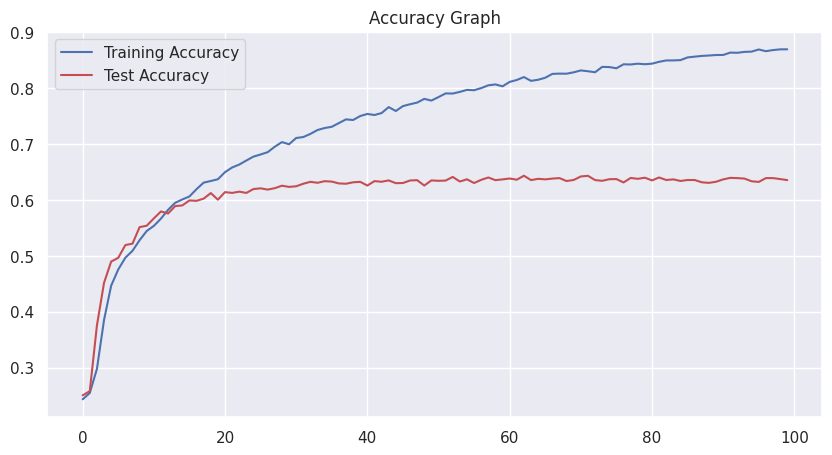

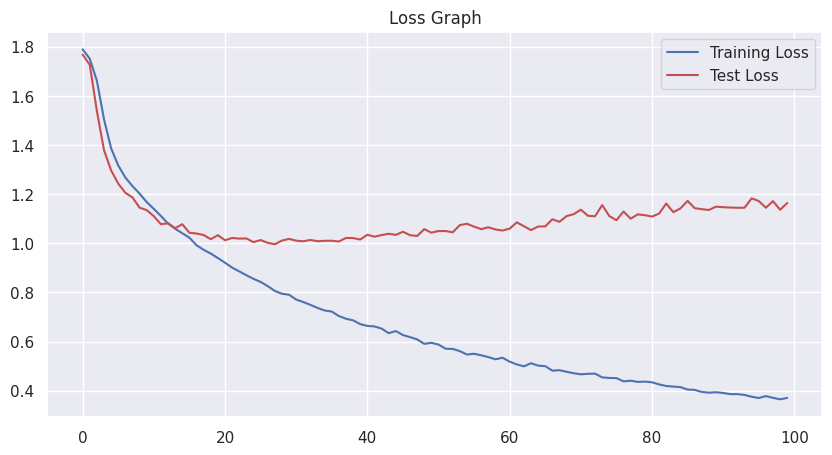

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Test Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Test Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');